In [ ]:
import torch
from torch import nn
from torchvision import models
import matplotlib.pyplot as plt

In [ ]:
net = models.resnet18(pretrained=True)
for p in net.parameters():
    p.requires_grad = False
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}
        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features

In [ ]:
layers = ["conv1", "layer2", "layer3", "avgpool"]
epsilon = 1e3
def get_random_noise_output(net, layers):
    noise = torch.randn(1, 3, 224, 224) # random noise
    noise.requires_grad = True
    extractor_net = FeatureExtractor(net, layers)
    out = extractor_net(noise)
    return noise, out

def plot_optimized_image(noise, epsilon):
    optim_img = noise.clone()
    optim_img += epsilon * noise.grad # gradient ascent
    plt.imshow(optim_img[0].permute(1, 2, 0).detach())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 64, 112, 112])


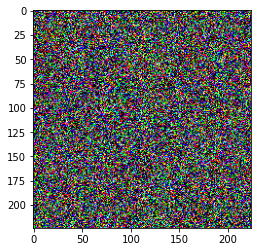

In [ ]:
noise, out = get_random_noise_output(net, layers)
oc1 = out["conv1"]
print(oc1.shape)
plt.imshow(noise[0].permute(1, 2, 0).detach())

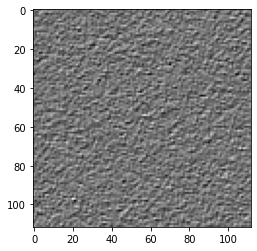

In [ ]:
plt.imshow(oc1[0, 0].detach(), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


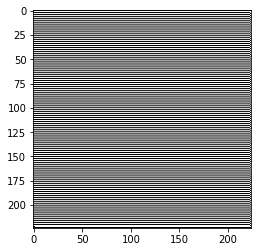

In [ ]:
oc1[0, 0, :, :].sum().backward() # channel optimization
plot_optimized_image(noise, epsilon) # this channel is interested in this pattern

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 128, 28, 28])


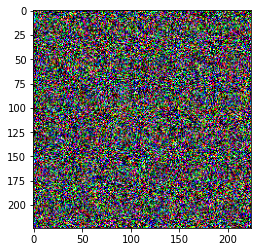

In [ ]:
noise, out = get_random_noise_output(net, layers)
ol2 = out["layer2"]
print(ol2.shape)
plt.imshow(noise[0].permute(1, 2, 0).detach())

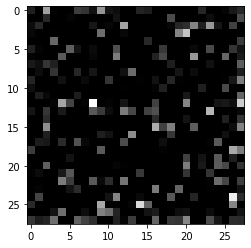

In [ ]:
plt.imshow(ol2[0, 20].detach(), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


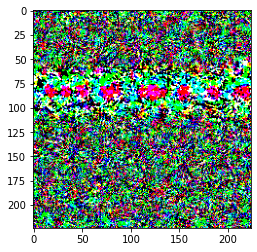

In [ ]:
ol2[0, 0, 10, :].sum().backward() # neuron-axis optimization
plot_optimized_image(noise, epsilon)# this neuron-axis is interested in this pattern

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 14, 14])


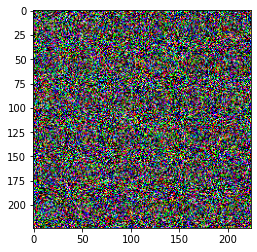

In [ ]:
noise, out = get_random_noise_output(net, layers)
ol3 = out["layer3"]
print(ol3.shape)
plt.imshow(noise[0].permute(1, 2, 0).detach())

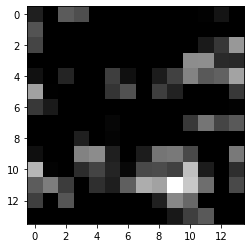

In [ ]:
plt.imshow(ol3[0, 200].detach(), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


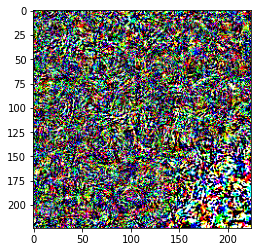

In [ ]:
ol3[0, 0, 12, 12].sum().backward() # neuron optimization
plot_optimized_image(noise, epsilon) # this neuron is interested in this pattern